# RNA-Seq data analysis for Zika infection study

_Zichen Wang_

There is a [Zika infection study](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE78711) on GEO, we want to compute the gene expression signature induced by Zika virus. 

So we go to the study, read through the descriptions of the study and samples. We extracted the following information:

`GSE=GSE78711`

`GPL=GPL18573`

`control_ids = [GSM2073121, GSM2073122, GSM2075585, GSM2075586]`

`perturbation_ids = [GSM2073123, GSM2073124, GSM2075587, GSM2075588]`


In [1]:
import numpy as np
import pandas as pd

In [2]:
## metadata
gse = 'GSE78711'
gpl = 'GPL18573'
ctrl_ids = ['GSM2073121', 'GSM2073122', 'GSM2075585', 'GSM2075586']
pert_ids = ['GSM2073123', 'GSM2073124', 'GSM2075587', 'GSM2075588']

In [3]:
## download the processed file
# !wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE78nnn/GSE78711/suppl/GSE78711_Table.S2A.reads_R1.xlsx

In [4]:
df = pd.read_excel('../GSE78711_Table.S2A.reads_R1.xlsx')
df

,Sample,Seq reads coverage (million),Mapped ratio,Seq method
0,Mock1-1,15.8,90.7% concordant pair alignment rate,Pair-end
1,Mock2-1,14.8,88.8% concordant pair alignment rate,Pair-end
2,ZIKV1-1,14.6,90.2% concordant pair alignment rate,Pair-end
3,ZIKV2-1,15.2,89.9% concordant pair alignment rate,Pair-end
4,Mock1-2,72.0,89.5% overall read mapping rate,Single-end
5,Mock2-2,92.0,89.4% overall read mapping rate,Single-end
6,ZIKV1-2,75.0,88.5% overall read mapping rate,Single-end
7,ZIKV2-2,66.0,88.2% overall read mapping rate,Single-end


In [5]:
# Download the SRA files
# !wget -r ftp://ftp-trace.ncbi.nlm.nih.gov/sra/sra-instant/reads/ByStudy/sra/SRP%2FSRP070%2FSRP070895/*

### Downloaded SRA files were processed in the following steps:
1. `fastq-dump` in the SRA-toolkit to generate .fastq files
2. `STAR` for the read alignment
3. `featureCounts` for assigning reads to genes
4. `edgeR` Bioconductor package were used to compute CPM and RPKM
---
Steps 1-3 were processed by `analyze_sra.sh`
Step 4 were done by `normalize.R`

---
After the above steps, we can start to analyze the processed expression matrix of genes in Python

In [21]:
## Check the alignment stats
!head ../featureCount_output/*.summary 

==> ../featureCount_output/Aligned.count.txt.summary <==
Status	/home/maayanlab/Zika/star_output/AlignedAligned.sortedByCoord.out.bam
Assigned	0
Unassigned_Ambiguity	0
Unassigned_MultiMapping	0
Unassigned_NoFeatures	0
Unassigned_Unmapped	0
Unassigned_MappingQuality	0
Unassigned_FragementLength	0
Unassigned_Chimera	0
Unassigned_Secondary	0

==> ../featureCount_output/SRR3191542.count.txt.summary <==
Status	/home/maayanlab/Zika/star_output/SRR3191542Aligned.sortedByCoord.out.bam
Assigned	3060
Unassigned_Ambiguity	4136
Unassigned_MultiMapping	13156
Unassigned_NoFeatures	6114
Unassigned_Unmapped	0
Unassigned_MappingQuality	0
Unassigned_FragementLength	0
Unassigned_Chimera	0
Unassigned_Secondary	0

==> ../featureCount_output/SRR3191543.count.txt.summary <==
Status	/home/maayanlab/Zika/star_output/SRR3191543Aligned.sortedByCoord.out.bam
Assigned	2688
Unassigned_Ambiguity	4019
Unassigned_MultiMapping	12291
Unassigned_NoFeatures	5498
Unassigned_Unmapped	0
Unassigned_MappingQuality	0
Unassigned

In [6]:
## load the expression matrix
expr_df = pd.read_csv('../repCpmMatrix_featureCounts.csv')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()

,SRR3191542,SRR3191543,SRR3191544,SRR3191545,SRR3194428,SRR3194429,SRR3194430,SRR3194431
Unnamed: 0,,,,,,,,
DDX11L1,0,0,0,0,0.000000,0.000000,0.020095,0.000000
WASH7P,0,0,0,0,2.491865,2.907422,2.190377,2.396793
MIR6859-2,0,0,0,0,0.000000,0.000000,0.000000,0.000000
MIR6859-1,0,0,0,0,0.000000,0.000000,0.000000,0.000000
FAM138A,0,0,0,0,0.000000,0.000000,0.000000,0.000000


In [7]:
print expr_df.shape

(25370, 8)


In [8]:
## filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
print expr_df.shape

## filter out lowly expressed genes
mask_low_vals = (expr_df > 0.3).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]

print expr_df.shape

(21876, 8)
(15665, 8)


We found this a `RunInfo Table` on the SRP page for this study [here](http://www.ncbi.nlm.nih.gov/Traces/study/?acc=SRP070895). This step should be automated in some way.

In [9]:
meta_df = pd.read_csv('../SraRunTable.txt', sep='\t').set_index('Run_s')
print meta_df.shape
# re-order the index to make it the same with expr_df
meta_df = meta_df.ix[expr_df.columns]
meta_df

(8, 27)


,BioSample_s,Experiment_s,LibraryLayout_s,LoadDate_s,MBases_l,MBytes_l,SRA_Sample_s,Sample_Name_s,infection_status_s,Assay_Type_s,...,Library_Name_s,Organism_s,Platform_s,ReleaseDate_s,SRA_Study_s,cell_type_s,g1k_analysis_group_s,g1k_pop_code_s,source_s,source_name_s
SRR3191542,SAMN04517925,SRX1602854,PAIRED,2016-02-26,1141,464,SRS1312741,GSM2073121,mock infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells
SRR3191543,SAMN04517926,SRX1602855,PAIRED,2016-02-26,1063,443,SRS1312740,GSM2073122,mock infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells
SRR3191544,SAMN04517927,SRX1602856,PAIRED,2016-02-26,1059,429,SRS1312738,GSM2073123,Zika infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells
SRR3191545,SAMN04517928,SRX1602857,PAIRED,2016-02-26,1095,445,SRS1312739,GSM2073124,Zika infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells
SRR3194428,SAMN04521221,SRX1605077,SINGLE,2016-02-29,5248,2383,SRS1314803,GSM2075585,mock infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells
SRR3194429,SAMN04521222,SRX1605078,SINGLE,2016-02-29,6806,3092,SRS1314802,GSM2075586,mock infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells
SRR3194430,SAMN04521223,SRX1605079,SINGLE,2016-02-29,5481,2495,SRS1314801,GSM2075587,Zika infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells
SRR3194431,SAMN04521224,SRX1605080,SINGLE,2016-02-29,4776,2181,SRS1314800,GSM2075588,Zika infected,RNA-Seq,...,<not provided>,Homo sapiens,ILLUMINA,2016-03-04,SRP070895,Neural Progenitor cells,<not provided>,<not provided>,<not provided>,human Neural Progenitor cells


In [10]:
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
sys.path.append('/Users/zichen/Documents/bitbucket/maayanlab_utils')
from fileIO import file2list
from plots import plot_venn
import RNAseq


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


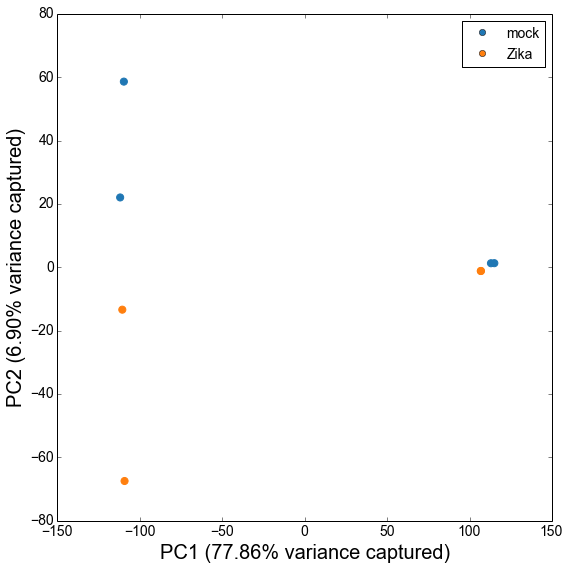

In [11]:
# plot PCA
%matplotlib inline
RNAseq.PCA_plot(expr_df.values, meta_df['infection_status_s'], 
         standardize=2, log=True, 
         show_text=False, sep=' ', legend_loc='upper right')

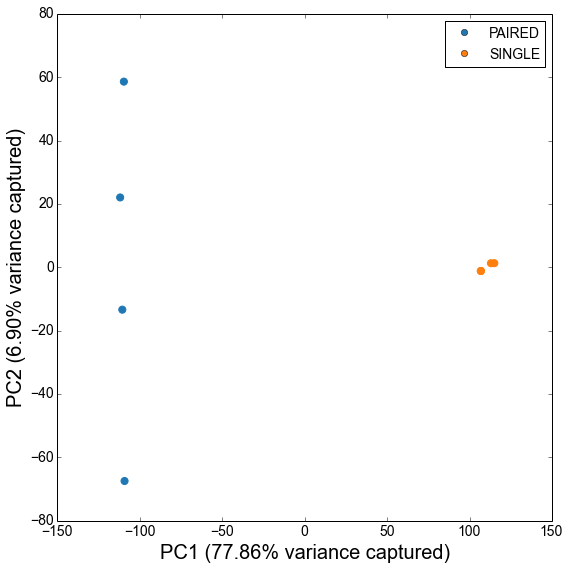

In [12]:
RNAseq.PCA_plot(expr_df.values, meta_df['LibraryLayout_s'], 
         standardize=2, log=True, 
         show_text=False, sep=' ', legend_loc='upper right')

In [13]:
import geode
d_layout_cd = {} # to top up/dn genes
cd_results = pd.DataFrame(index=expr_df.index)
for layout in meta_df['LibraryLayout_s'].unique():
    ## make sample_class 
    sample_class = np.zeros(expr_df.shape[1], dtype=np.int32)
    sample_class[meta_df['LibraryLayout_s'].values == layout] = 1
    sample_class[(meta_df['LibraryLayout_s'].values == layout) & 
                 (meta_df['infection_status_s'].values == 'Zika infected')] = 2
    print layout, sample_class
    
    cd_res = geode.chdir(expr_df.values, sample_class, expr_df.index, 
                      gamma=.5, sort=False, calculate_sig=False)
    cd_coefs = np.array(map(lambda x: x[0], cd_res))
    cd_results[layout] = cd_coefs
    
    # sort CD in by absolute values in descending order
    srt_idx = np.abs(cd_coefs).argsort()[::-1]
    cd_coefs = cd_coefs[srt_idx][:600]
    sorted_DEGs = expr_df.index[srt_idx][:600]
    # split up and down
    up_genes = dict(zip(sorted_DEGs[cd_coefs > 0], cd_coefs[cd_coefs > 0]))
    dn_genes = dict(zip(sorted_DEGs[cd_coefs < 0], cd_coefs[cd_coefs < 0]))
    d_layout_cd[layout+'-up'] = up_genes
    d_layout_cd[layout+'-dn'] = dn_genes

print cd_results.head()

PAIRED [1 1 2 2 0 0 0 0]
SINGLE [0 0 0 0 1 1 2 2]
                PAIRED    SINGLE
Unnamed: 0                      
WASH7P       -0.000024 -0.001020
LOC729737    -0.147537 -0.000580
LOC100133331  0.008199 -0.000900
MIR6723       0.008570 -0.001006
LOC100288069 -0.000024 -0.000698


In [14]:
## Check the cosine distance between the two signatures
from scipy.spatial.distance import cosine
print cosine(cd_results['PAIRED'], cd_results['SINGLE'])

0.774249079115


(-100, 15765)

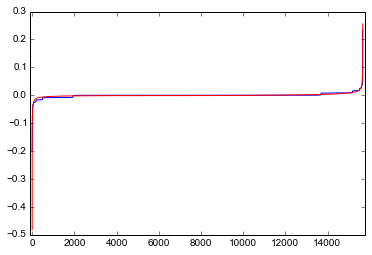

In [15]:
x = cd_results['PAIRED'].copy()
x.sort()
plt.plot(x, color='b')
x = cd_results['SINGLE'].copy()
x.sort()
plt.plot(x, color='r')
plt.xlim([-100, len(x)+ 100])

In [16]:
## generate Enrichr links for up/down genes
RNAseq.dict2xls_with_vals(d_layout_cd, ['gene', 'CD coef'], '../Enrichr_links_CD600.xls')

In [17]:
## Check the Enrichr results
enrichr_results = pd.read_excel('../Enrichr_links_CD600.xls', sheetname=None)
print enrichr_results.keys()

[u'Enrichr_links', u'SINGLE-dn', u'PAIRED-dn', u'PAIRED-up', u'SINGLE-up']


In [18]:
from pprint import pprint
for i, row in enrichr_results['Enrichr_links'].iterrows():
    print row['Gene list'], row['Size'], row['Link']


PAIRED-dn 254 http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=5uft
PAIRED-up 346 http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=5ufu
SINGLE-dn 193 http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=5ufv
SINGLE-up 407 http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=5ufw


In [19]:
import requests, json
def post_to_cds2(genes, vals, name=None, aggravate=False):
    ## post CD signature to L1000CDS2 API and return a CDS2 url
    url = 'http://amp.pharm.mssm.edu/L1000CDS2/query'
    cds2_url = None

    data = {
        "genes": map(lambda x: x.upper(), genes), 
        "vals":  vals
        }
    config = {"aggravate":aggravate,"searchMethod":"CD","share":True,"combination":True,"db-version":"latest"}
    metadata = [{"key":"name","value": name}]

    payload = {"data":data,"config":config,"meta":metadata}
    headers = {'content-type':'application/json'}
    r = requests.post(url,data=json.dumps(payload),headers=headers)
    resCD = r.json()
    shareId = resCD['shareId']
    cds2_url = 'http://amp.pharm.mssm.edu/L1000CDS2/#/result/' + shareId
    return cds2_url

In [20]:
## get URL from L1000CDS2
for col in cd_results:
    res = cd_results[col].copy()
    srt_idx = np.abs(res).argsort()
    res = res[srt_idx]
    genes = res[:2000].index.tolist()
    vals = res[:2000].tolist()
    cds2_url = post_to_cds2(genes, vals, name=col, aggravate=True)
    print col, cds2_url

PAIRED http://amp.pharm.mssm.edu/L1000CDS2/#/result/57163620bfccf1840181ce68
SINGLE http://amp.pharm.mssm.edu/L1000CDS2/#/result/57163623bfccf1840181ce6a
